# **Building an Intelligent Text-to-Speech Agent**

## **Overview**
This ai agent will guides me through the process of creating an advanced text-to-speech (TTS) agent using LangGraph and google's APIs. The agent can classify input text, process it based on its content type, and generate corresponding speech output.
## **Motivations**  
in the era of AI and natural language processing, there's a growing need for systems that can intelligently process and vocalize text. This project aims to create a versatile TTS agent that goes beyond simple text-to-speech conversion by understanding and adapting to different types of content.
## **Key Components**
1. Content Classification: Utilizes OpenAI's GPT models to categorize input text.
2. Content Processing: Applies specific processing based on the content type (general, poem, news, or joke).
3. Text-to-Speech Conversion: Leverages huggingface's TTS API to generate audio from processed text.
4. LangGraph Workflow: Orchestrates the entire process using a state graph.

## **Method**
The TTS agent operates through the following high-level steps:

1. Text Input: The system receives a text input from the user.
2. Content Classification: The input is classified into one of four categories: general, poem, news, or joke.
3. Content-Specific Processing: Based on the classification, the text undergoes specific processing:
 - General text remains unchanged
 - Poems are rewritten for enhanced poetic quality
 - News is reformatted into a formal news anchor style
 - Jokes are refined for humor
4. Text-to-Speech Conversion: The processed text is converted to speech using an appropriate voice for its content type.
5. Audio Output: The generated audio is either saved to a file or played directly, depending on user preferences.

The entire workflow is managed by a LangGraph state machine, ensuring smooth transitions between different processing stages and maintaining context throughout the operation.

## **Conclusion :**  

This intelligent TTS agent demonstrates the power of combining language models for content understanding with speech synthesis technology. It offers a more nuanced and context-aware approach to text-to-speech conversion, opening up possibilities for more natural and engaging audio content generation across various applications, from content creation to accessibility solutions.


By leveraging the strengths of GPT models for text processing and OpenAI's TTS capabilities, this project showcases how advanced AI technologies can be integrated to create sophisticated, multi-step language processing pipelines.

## **neccessary libraries and set up Environment**

In [ ]:
!pip install langchain langchain_community langgraph langchain_openai  google-generativeai


In [10]:
from typing import TypedDict
from langgraph.graph import Graph , END  , StateGraph
from IPython.display import display , Audio  , Markdown
from openai import OpenAI
from dotenv import load_dotenv
import io
import tempfile
import re
import os
load_dotenv()
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api')
os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api')


## initialize Models and Define State

In [4]:
client =  OpenAI()
import google.generativeai as genai
model = genai.GenerativeModel("gemini-pro")


In [5]:
class AgentState(TypedDict):
     input_text : str
     processed_text : str
     content_type : str
     audio_data :  bytes
     audio_path  :  str


## **Define Node Functions**


In [8]:
def classify_content(state : AgentState ) -> AgentState :
    query =state["input_text"]
    response =  model.generate_content(f"The given text is '{query}'. Classify the content as one of: 'general', 'poem', 'news', 'joke'.give me just type of content")
    state["content_type"] =  response.text.strip()
    return state

def process_general(state: AgentState) -> AgentState:
    """Process general content (no specific processing, return as-is)."""
    state["processed_text"] = state["input_text"]
    return state

def process_poem(state: AgentState) -> AgentState:
    """Process the input text as a poem, rewriting it in a poetic style."""
    response =  model.generate_content(f"Rewrite the following text {state['input_text']} as a short, beautiful poem:")
    state["processed_text"] = response.text.strip()
    return state


def process_news(state: AgentState) -> AgentState:
    """Process the input text as news, reformatting it into a formal news anchor style."""
    response =  model.generate_content(f"Reformat the following text {state['input_text']} into a formal news anchor style:")
    state["processed_text"] = response.text.strip()
    return state

def process_joke(state: AgentState) -> AgentState:
    """Process the input text as a joke, refining it for humor."""
    response =  model.generate_content(f"Refine the following text {state['input_text']} for humor , a short funny jokes.")
    state["processed_text"] = response.text.strip()
    return state


def text_to_speech(state: AgentState, save_file: bool = False) -> AgentState:
    """
    Converts processed text into speech using a voice mapped to the content type.
    Optionally saves the audio to a file.

    Args:
        state (AgentState): Dictionary containing the processed text and content type.
        save_file (bool, optional): If True, saves the audio to a file. Defaults to False.

    Returns:
        AgentState: Updated state with audio data and file path (if saved).
    """
    voice_map = {
        "general": "alloy",
        "poem": "nova",
        "news": "onyx",
        "joke": "shimmer"
    }
    voice = voice_map.get(state["content_type"], "alloy")
    audio_data = io.BytesIO()
    with client.audio.speech.with_streaming_response.create(
        model="tts-1",
        voice=voice,
        input=state["processed_text"]
    ) as response:
        for chunk in response.iter_bytes():
            audio_data.write(chunk)

    state["audio_data"] = audio_data.getvalue()

    # Save audio to a file if requested
    if save_file:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp3") as temp_audio:
            temp_audio.write(state["audio_data"])
            state["audio_path"] = temp_audio.name
    else:
        state["audio_path"] = ""

    return state


## **Define and Compile the Graph**

In [16]:
workflow =  StateGraph(AgentState)

workflow.add_node("classify_content" , classify_content)
workflow.add_node("process_general" , process_general)
workflow.add_node("process_poem" , process_poem)
workflow.add_node("process_news" , process_news)
workflow.add_node("process_joke" , process_joke)
workflow.add_node("text_to_speech" , text_to_speech)


# set the entry

workflow.set_entry_point("classify_content")

# Modify the targets to be strings instead of lists
workflow.add_conditional_edges(
    "classify_content",
    lambda x :x["content_type"],
    {
        "general": "process_general", # Changed from ["process_general"]
        "poem": "process_poem",       # Changed from ["process_poem"]
        "news": "process_news",       # Changed from ["process_news"]
        "joke": "process_joke"        # Changed from ["process_joke"]
    }
)

workflow.add_edge("process_general", "text_to_speech")
workflow.add_edge("process_poem", "text_to_speech")
workflow.add_edge("process_news", "text_to_speech")
workflow.add_edge("process_joke", "text_to_speech")
workflow.add_edge("text_to_speech", END)
# Compile the graph
app = workflow.compile()

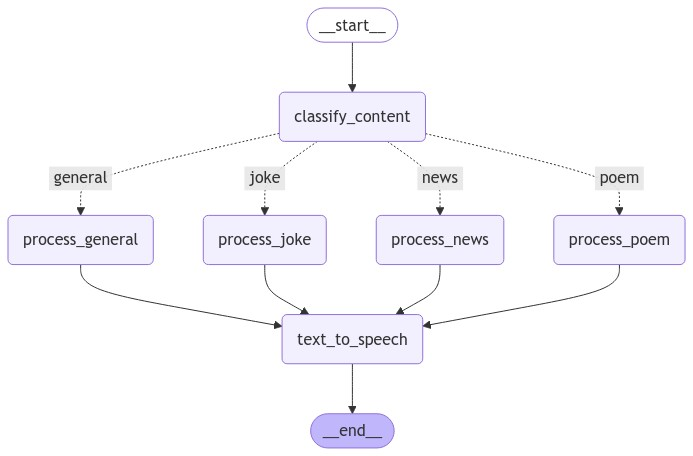

In [20]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Define Function to Run Agent and Play Audio and Test the Text-to-Speech Agent

In [ ]:
import os
import re
import time
from IPython.display import Audio, Markdown, display
import openai  # Make sure you have the openai library installed

def sanitize_filename(text, max_length=20):
    """Convert text to a valid and concise filename."""
    sanitized = re.sub(r'[^\w\s-]', '', text.lower())
    sanitized = re.sub(r'[-\s]+', '_', sanitized)
    return sanitized[:max_length]

def run_tts_agent_and_play(input_text: str, content_type: str, save_file: bool = True):
    # Add a delay to avoid exceeding the rate limit
    time.sleep(1)  # Adjust the delay as needed

    result = app.invoke({
        "input_text": input_text,
        "processed_text": "",
        "audio_data": b"",
        "audio_path": "",
        "content_type": content_type
    })
    print(f"Detected content type: {result['content_type']}")
    print(f"Processed text: {result['processed_text']}")
    display(Audio(result['audio_data'], autoplay=True))
    if save_file:
        # Create 'audio' directory in the parent folder of the notebook
        audio_dir = os.path.join('..', 'audio')
        os.makedirs(audio_dir, exist_ok=True)

        sanitized_text = sanitize_filename(input_text)
        file_name = f"{content_type}_{sanitized_text}.mp3"
        file_path = os.path.join(audio_dir, file_name)

        with open(file_path, "wb") as f:
            f.write(result['audio_data'])

        print(f"Audio saved to: {file_path}")

        # Relative path for GitHub
        github_relative_path = f"../audio/{file_name}"
        display(Markdown(f"[Download {content_type} audio: {sanitized_text}]({github_relative_path})"))

        # Note about GitHub limitations
        print("Note: Audio playback is not supported directly on GitHub. Use the download link to listen to the audio.")
    else:
        print("Audio not saved to file.")

    return result

examples = {
    "general": "The quick brown fox jumps over the lazy dog.",
    "poem": "Roses are red, violets are blue, AI is amazing, and so are you!",
    "news": "Breaking news: Scientists discover a new species of deep-sea creature in the Mariana Trench.",
    "joke": "Why don't scientists trust atoms? Because they make up everything!"
}

for content_type, example in examples.items():
    result = run_tts_agent_and_play(example, content_type, save_file=True)
    print("--" * 20)